# Создание анимации с помощью ffmpeg

Рассмотрим способ создания анимированных кривых с помощью библиотеки `matplotlib` и утилиты `ffmpeg`. Несмотря на то, что в `matplotlib` встроены собственные средства для создания анимации, подход с использованием `ffmpeg` более универсален, так как его можно использовать в связке не только с `matplotlib`, но и с любыми другими библиотеками и утилитами для визуализации данных.

Программа `ffmpeg` представляет собой утилиту, способную кодировать и декодировать видеофайлы, а также создавать видео из набора растровых изображений. Мы рассмотрим способ создания видеофайла в формате `mp4` из набора `png` файлов, которые будут генерироваться с помощью библиотеки `matplotlib`. Также мы используем модуль `subprocess` из стандартной библиотеки языка `Python` для вызова `ffmpeg` непосредственно из python-программы.

Утилиту `ffmpeg` можно скачать на [официальном сайте](https://www.ffmpeg.org/download.html). Доступны сборки практически для всех операционных систем. Утилита представляет собой один исполняемый файл. В данном примере рассмотрим запуск `ffmpeg` под операционной системы Windows, однако он с минимальными изменениями может быть перенесен на случай `Unix/GNU Linux` и `MacOS`.

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import subprocess
import os

In [2]:
plt.style.use('../default_colors.mplstyle')

В качестве примера рассмотрим анимации циклоиды, которую описывает зафиксированная точка на катящейся окружности. Мы загрузили модули`matplotlib.patches` и `matplotlib.lines` для создания примитивов (отрезков прямой и окружностей). Начнем с того, что создадим параметрическую функцию, задающую точки циклоиды.
$$
\mathbf{r}(t) = 
\begin{pmatrix}
    R(t-\sin{t})\\
    R(1 - \cos{t})
\end{pmatrix}
$$

In [3]:
def cycloid(t, R=3.0):
    '''Уравнение циклоиды'''
    return np.array([R*(t - np.sin(t)),
                     R*(1 - np.cos(t))])

In [5]:
# укажем директорию, в которую будем 
# сохранять сгенерированные картинки
FOLDER = 'cycloid'
try:
    os.mkdir(FOLDER)
except FileExistsError:
    pass

x_max=25.132741228718345, y_max=4.0

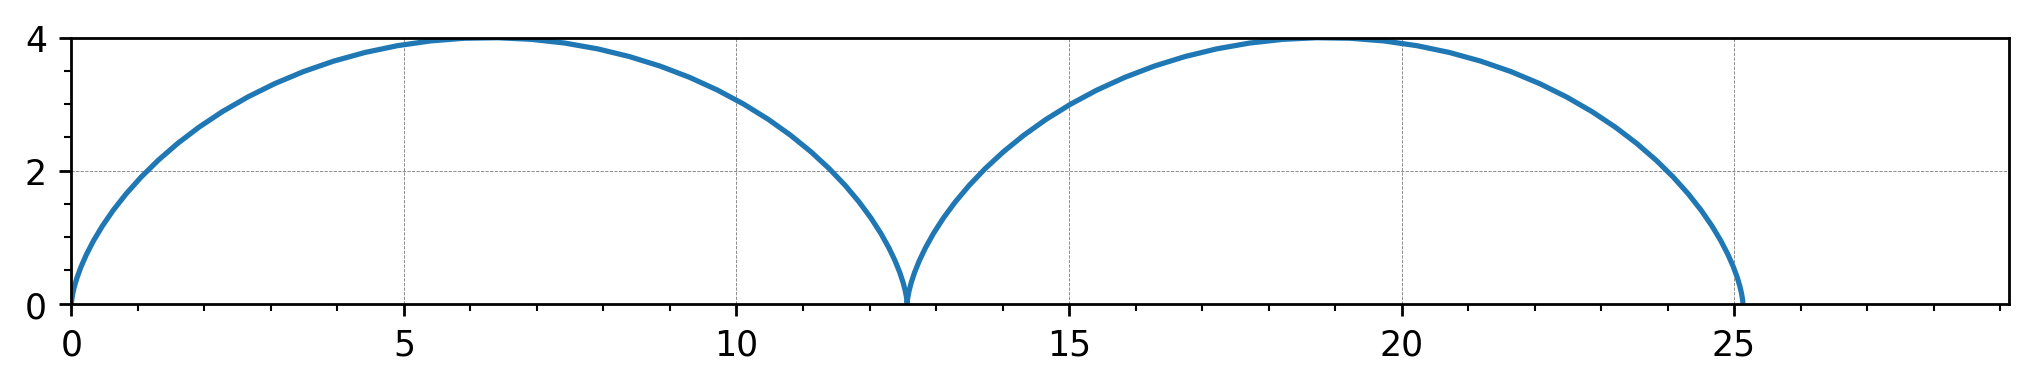

In [17]:
fig01 = plt.figure(num=1, figsize=(10, 5))
ax01 = fig01.add_subplot(1, 1, 1)

ax01.set_aspect('equal')

# радиус генерирующей окружности
R = 2.0
# Границы параметра. Он имеет смысл угла поворота окружности
t_min = 0
t_max = 4*np.pi

# Сколько значений параметра возьмем, столько точек и получим
N = 100
# Все значения параметра
T = np.linspace(start=t_min, stop=t_max, num=N)
# Все точки циклоиды
X, Y = cycloid(T, R=R)

x_max = np.max(X)
y_max = 2*R

print(f"{x_max=}, {y_max=}")

# задаем границы осей, чтобы картинка не прыгала
ax01.set_xlim(left=0, right=x_max + 2*R)
ax01.set_ylim(bottom=0, top=2*R)

# Нарисуем контур циклоиды заранее серым цветом
ax01.plot(X, Y, lw=0.5, ls='-', color='gray')

# Пустая заготовка линии циклоиды. В нее будем добавлять 
# точки циклоиды по мере продвижения окружности
cycloid_line, = ax01.plot([], [])

for i in range(N):
    
    # последняя точка кривой
    x, y = X[i], Y[i]
    
    # центр окружности в точке (Rt, R), так как за время t окружность прокатывается 
    # на расстояние Rt (длина дуги окружности)
    C = (R*T[i], R)
    
    # Генерирующая окружность с центром
    circ = mpatches.Circle(xy=C, radius=R, fill=False, color='black')
    # Точка на катящейся окружности
    point = mpatches.Circle(xy=(x, y), radius=0.1, fill=True, color='black')
    # добавляем на картинку окружность и точку
    ax01.add_patch(circ)
    ax01.add_patch(point)
  
    # Добавляем очередную точку циклоиды к заготовке линии
    cycloid_line.set_xdata(np.append(cycloid_line.get_xdata(), x))
    cycloid_line.set_ydata(np.append(cycloid_line.get_ydata(), y))

    # сохраняем окружность
    fig01.savefig(f'{FOLDER}/{i:03d}.png', dpi=300, format='png')
    # Удаляем только окружность и точку на ней
    del ax01.patches[:]
    print('=', end='')

После завершения работы программы, будет создана директория `cycloid`, куда будут сохранены все сгенерированные картинки. Для сборки картинок в видеофайл следует запустить `ffmpeg` в консоли со следующими опциями:
```batch
G:\Program Files\ffmpeg\bin\ffmpeg.exe -y -r 30 -f image2 -i cycloid\%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p cycloid.mp4
```
Здесь указан полный путь до исполняемого файла `ffmpeg`, который зависит от способа установки и может различаться на разных компьютерах. Все остальные опции следует указать без изменения вне зависимости от операционной системы. Не будем вдаваться в подробности опций, укажем лишь, что `cycloid\%03d.png` обозначает файлы в директории `cycloid` с именами из трех цифр: начиная от `000.png` и заканчивая `999.png`. Последним в аргументом указано имя создаваемого видео-файла `cycloid`.

Следующий пример показывает, как запустить `ffmpeg` непосредственно из python программы не открывая консоль.

In [18]:
# FFMPEG = 'G:\\Program Files\\ffmpeg\\bin\\ffmpeg.exe'
FFMPEG = 'ffmpeg'

CMD = [FFMPEG, '-y', '-r', '30', '-f', 'image2', '-i', f'{FOLDER}/%03d.png',
       '-vcodec', 'libx264', '-crf', '25', '-pix_fmt', 'yuv420p', 'cycloid.mp4']
print(' '.join(CMD))
subprocess.run(CMD)

ffmpeg -y -r 30 -f image2 -i cycloid/%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p cycloid.mp4


CompletedProcess(args=['ffmpeg', '-y', '-r', '30', '-f', 'image2', '-i', 'cycloid/%03d.png', '-vcodec', 'libx264', '-crf', '25', '-pix_fmt', 'yuv420p', 'cycloid.mp4'], returncode=0)

В результате будет создан видеофайл `cycloid.mp4` с анимацией катящейся окружности, точка которой отрисовывает линию циклоиды.